# RESEGMENTATION PIPELINE

## Set up source and destination folders

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box


In [2]:
ddir = 'G:\\Alexis_data\\Project\\SpatialOmics_cellpose\\results'
base_path = "G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738"

# Select first and third hannels for segmentation (can only select two) 
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"   
fullres_chanel_2 = f"{base_path}\morphology_focus\morphology_focus_0002.ome.tif"
sample_name = "1886od"
ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}

# Define resolution level and crop size in pixels
level = 0
pixelsize = scalefactors[level]

# Define patch size
crop_size = 600/pixelsize

## Define the region of interest (ROI)

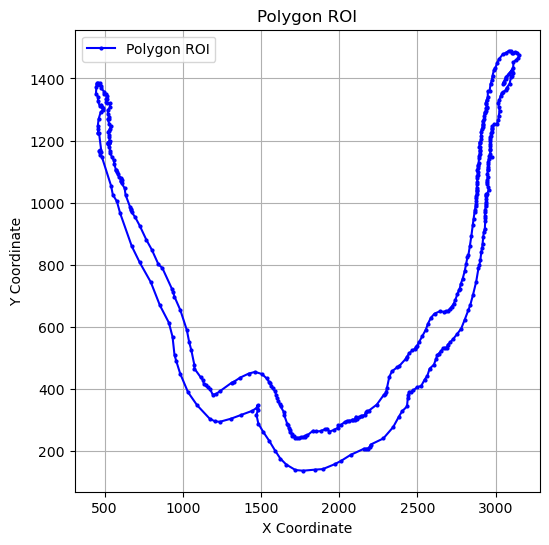

In [ ]:
# Read the ROI coordinates from the CSV file
from SRC_RESEG.crop_image import *
plot_roi(ROI_filepath)
polygon_coords = pd.read_csv(ROI_filepath)
# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


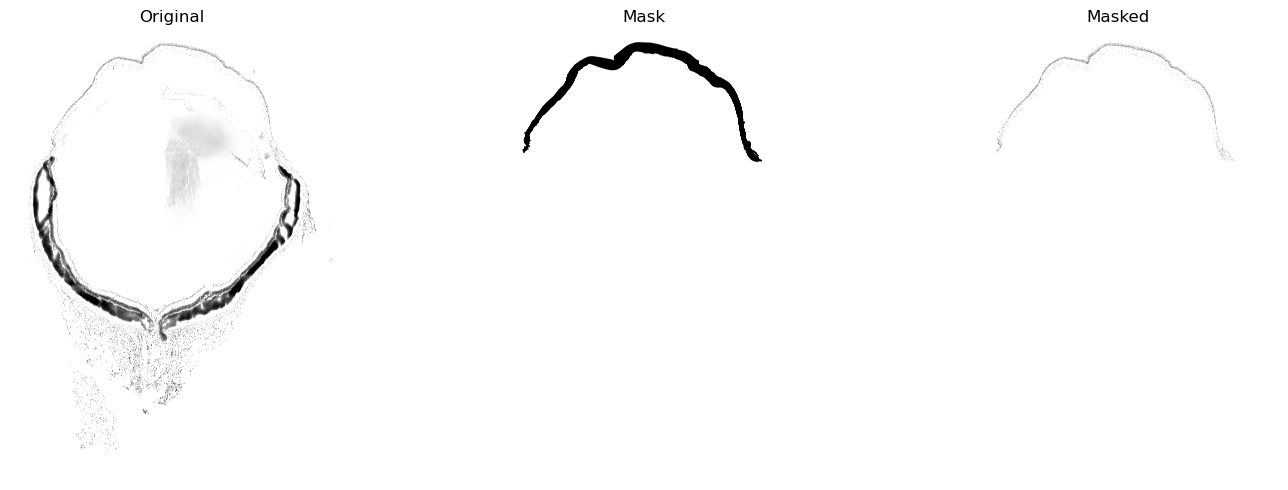

In [9]:
mask, masked_img_0 = mask_polygon_from_tif(
    fullres_chanel_0,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)

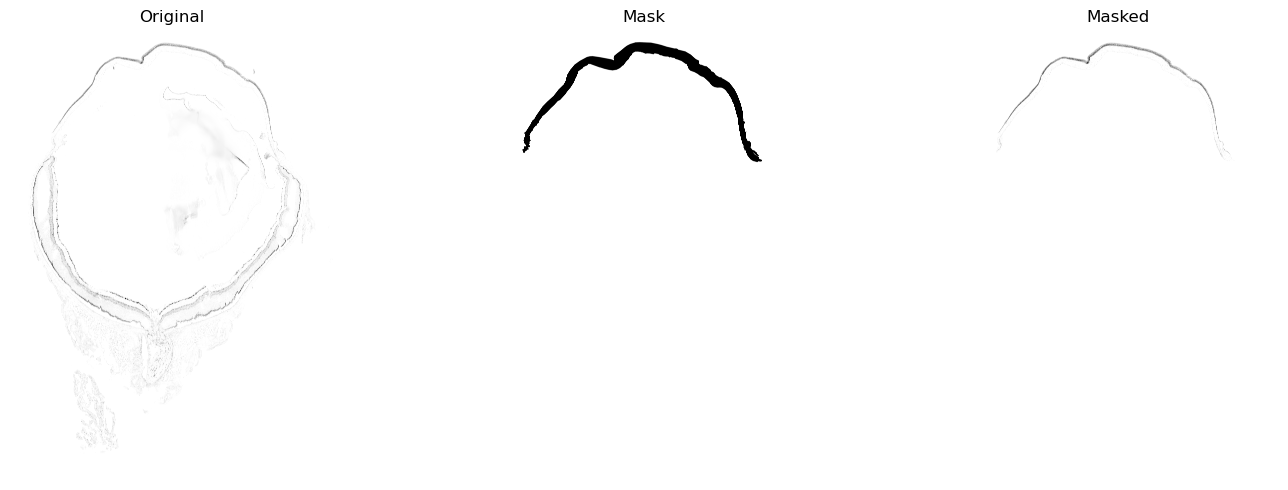

In [10]:
mask, masked_img_2 = mask_polygon_from_tif(
    fullres_chanel_2,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)


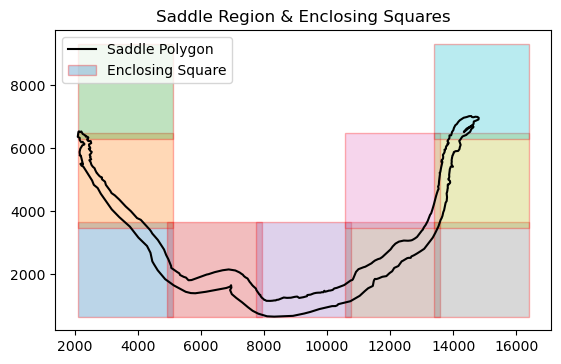

square: POLYGON ((5103.235294117647 645, 5103.235294117647 3656.235294117647, 2092 3656.235294117647, 2092 645, 5103.235294117647 645))
 x: array('d', [5103.235294117647, 5103.235294117647, 2092.0, 2092.0, 5103.235294117647]) 
 y: array('d', [645.0, 3656.235294117647, 3656.235294117647, 645.0, 645.0])
square: POLYGON ((5103.235294117647 3468, 5103.235294117647 6479.235294117647, 2092 6479.235294117647, 2092 3468, 5103.235294117647 3468))
 x: array('d', [5103.235294117647, 5103.235294117647, 2092.0, 2092.0, 5103.235294117647]) 
 y: array('d', [3468.0, 6479.235294117647, 6479.235294117647, 3468.0, 3468.0])
square: POLYGON ((5103.235294117647 6291, 5103.235294117647 9302.235294117647, 2092 9302.235294117647, 2092 6291, 5103.235294117647 6291))
 x: array('d', [5103.235294117647, 5103.235294117647, 2092.0, 2092.0, 5103.235294117647]) 
 y: array('d', [6291.0, 9302.235294117647, 9302.235294117647, 6291.0, 6291.0])
square: POLYGON ((7926.235294117647 645, 7926.235294117647 3656.235294117647, 4

In [ ]:
# Combine X and Y into coordinate pairs
x_coords_rescaled = x_coords / pixelsize
y_coords_rescaled = y_coords / pixelsize
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
# Define square size
square_size = int(crop_size)
# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_overlapping_squares(rescaled_polygon_roi, square_size)


plot_polygon_and_squares(
    rescaled_polygon_roi,
    overlapping_squares,
    title="Saddle Region & Enclosing Squares",
    polygon_label="Saddle Polygon",
    square_label="Enclosing Square"
)

for square in overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
